In [1]:
"""Useful modules"""
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import minimize, Bounds

In [2]:
class GaussianFitter():
    
        def __init__(self):
            #Initialisation. Fitted flag is so people don't try to predict before fitting.
            self.fitted = False
            
        def quick_log_det(self,mat):
            #Sum the logs of the R matrix from a QR decomposition is a quick way to take the log of a determinant.
            q,r = np.linalg.qr(mat)
            ans = sum(np.log(np.abs(np.diag(r))))
            return ans
        
        def dirac(self,a,b):
            #The dirac delta function
            if a == b:
                return 1
            else:
                return 0
            
        def squared_distances(self,A,B):
            #Makes a matrix of squared distances between two vectors
            n=A.shape[0]
            m=B.shape[0]
            D=np.zeros((n,m))
            for i in range(n):
                for j in range(m):
                    D[i,j]=np.linalg.norm(A[i]-B[j])**2
            return D
            
        def Sigma_maker(self,X,alpha,length,sigma):
            #Makes the Sigma matrix used in a number of Gaussian process calculations
            Sigma = np.zeros(shape=(np.size(X),np.size(X)))
            for i in range(np.size(X)):
                for j in range(np.size(X)):
                    Sigma[i,j] = (alpha**2)*np.exp(-((X[i]-X[j])**2)/(2*(length**2)))+self.dirac(i,j)*sigma**2
            return Sigma
            
        def grad_maker(self,theta,X):
            #Generates the matrices of gradients for each hyperparameter
            
            #Store the dimensions (everything's square or a single column so we only need one value)
            d = np.shape(X)[0]

            #Initialise the matrices
            grad_Sigma_alpha = np.zeros(shape=(d,d))
            grad_Sigma_length = np.zeros(shape=(d,d))
            grad_Sigma_sigma = np.zeros(shape=(d,d))

            #We don't need any fancy math, can just set everything to one and be done.
            grad_mu_nu = np.ones(shape=(d))

            #Go through each row and column and calculate the value for that element.
            for i in range(d):
                for j in range(d):
                    grad_Sigma_alpha[i,j] = (2*theta[0])*np.exp((-((X[i]-X[j])**2))/(2*(theta[1]**2)))
                    grad_Sigma_length[i,j] = ((theta[0]**2)*(((X[i]-X[j])**2)/(theta[1]**3))
                                              *np.exp((-((X[i]-X[j])**2))/(2*(theta[1]**2))))
                    grad_Sigma_sigma[i,j] = 2*theta[2]*self.dirac(i,j)

            return grad_Sigma_alpha,grad_Sigma_length,grad_Sigma_sigma,grad_mu_nu
        
        def grad_NLL_theta(self,theta,X,y):
            #Return the calculated gradients of the NLL with each hyperparameter

            #Generate the necessary matrices
            grad_Vector =self.grad_maker(theta,X)
            Sigma=self.Sigma_maker(X,theta[0],theta[1],theta[2])
            Sigma_inv = np.linalg.inv(Sigma) #We can save time by inverting it just once and storing the result.

            #Calculate the scalar gradient results.
            grad_alpha = 0.5*(np.trace(np.matmul(Sigma_inv,grad_Vector[0]))
                              -np.matmul(np.matmul(np.matmul(np.matmul(np.transpose(y-theta[3]),Sigma_inv),
                                grad_Vector[0]),Sigma_inv),(y-theta[3])))
            grad_length = 0.5*(np.trace(np.matmul(Sigma_inv,grad_Vector[1]))
                              -np.matmul(np.matmul(np.matmul(np.matmul(np.transpose(y-theta[3]),Sigma_inv),
                                grad_Vector[1]),Sigma_inv),(y-theta[3])))
            grad_sigma = 0.5*(np.trace(np.matmul(Sigma_inv,grad_Vector[2]))
                              -np.matmul(np.matmul(np.matmul(np.matmul(np.transpose(y-theta[3]),Sigma_inv),
                                grad_Vector[2]),Sigma_inv),(y-theta[3])))
            grad_nu = 0.5*(-2*np.matmul(np.matmul(grad_Vector[3],Sigma_inv),(y-theta[3])))
            
            return grad_alpha,grad_length,grad_sigma,grad_nu
        
        def loss(self,theta,X,y):
            #Negative Loss Likelihood function. We're aiming to minimise this (ie. maximise likelihood)
            
            #Store dimension and generate sigma matrix
            d = np.shape(X)[0]
            Sigma = self.Sigma_maker(X,theta[0],theta[1],theta[2])
            
            #Calculate NLL
            NLL = np.sum(0.5*(d*np.log(2*np.pi)+self.quick_log_det(Sigma)+np.matmul(np.matmul(np.transpose(y-theta[3]),np.linalg.inv(Sigma)),(y-theta[3]))))
            return NLL
        
        def Sigma_combiner(self,theta,X1,X2,y):
            #Generates the sigma matrices used for defininig the prior and posterior distributions.
            SIG11=theta[0]**2*np.exp(-self.squared_distances(X1,X1)/(2*theta[1]**2))+theta[2]**2*np.identity(np.shape(X1)[0])
            SIG22=theta[0]**2*np.exp(-self.squared_distances(X2,X2)/(2*theta[1]**2))
            SIG21=theta[0]**2*np.exp(-self.squared_distances(X2,X1)/(2*theta[1]**2))
            SIG12=theta[0]**2*np.exp(-self.squared_distances(X1,X2)/(2*theta[1]**2))

            #Produce the distribution parameter results
            mu=theta[3]+np.matmul(SIG21,np.linalg.solve(SIG11,(y-theta[3])))
            SIG=SIG22-np.matmul(SIG21,np.linalg.solve(SIG11,SIG12))
            std=np.diag(SIG)**0.5

            return mu,std,SIG,SIG22

        def fit(self,X,y,nstarts = 25,y_std_scale = 0.01,bounded_sigma = True,tol=None):
            #Optimises the hyperparameters using scipy minimise.
            
            #Sets a lower boundary for the variance to avoid numerical instability on matrix inversion
            min_sigma = y_std_scale*np.std(y)
            #You can turn it off but it's not recommended.
            if bounded_sigma == True:
                bnds = ((1e-10,None),(1e-10,None),(min_sigma,None),(None,None)) #Gets funny if set 0 as a bound for alpha and l so we use 1e-10 instead.
            else: 
                bnds = ((1e-10,None),(1e-10,None),(None,None),(None,None))
            done = False
            i = 0
            #Repeat the fit from 10 random starts due to the non-convexity of the function
            for i in range(nstarts):
                init_start = [np.random.uniform(0,100),np.random.uniform(0,100),np.random.uniform(min_sigma,100),np.random.uniform(-100,100)]
                results_new = minimize(self.loss,init_start,method="SLSQP",jac=self.grad_NLL_theta,args=(X,y),bounds=bnds,tol=tol)
                if i == 0:
                    results = results_new
                if results_new.fun < results.fun: #If the NLL is lower
                    results = results_new #Update the results with the new one
            self.best_fit_NLL = results.fun #Store the minimum NLL achieved
            print('Lowest NLL achieved = '+str(results.fun)) #Report the minimum NLL achieved
            self.params = results.x #Store the parameters at this minimum NLL
            self.fitted = True #Flag that the model's been fitted (and hence optimum parameters are set)
            
        def predict(self,X,y,lbound=-3,ubound=3,npreds=100,alpha=0.1):
            #Plots the prior and posterior distirbution along with a regression of our results with prediction.
            if self.fitted == False:
                print('Please use the fit function first.')
            else:
                X_pred = np.linspace(lbound,ubound,npreds)
                mu,std,SIG,SIG22 = self.Sigma_combiner(self.params,X,X_pred,y)
                
                sample_pri=np.random.multivariate_normal(np.ones(npreds)*self.params[3],SIG22)
                sample_pos=np.random.multivariate_normal(mu,SIG)
    
                plt.figure(figsize=(15,5))
                plt.subplot(131)
                plt.plot(X,y,'x')
                plt.plot(X_pred,mu)
                plt.fill_between(X_pred, mu-std, mu+std,alpha=alpha)
                plt.title('Regression data with prediction')
                plt.xlabel('$x$')
                plt.ylabel('$y$')

                plt.subplot(132)
                plt.plot(X_pred,sample_pri)
                plt.title('Sample from prior distribution')
                plt.xlabel('$x$')
                plt.ylabel('$y$')

                plt.subplot(133)
                plt.plot(X_pred,sample_pos)
                plt.plot(X,y,'x')
                plt.title('Sample from posterior distribution')
                plt.xlabel('$x$')
                plt.ylabel('$y$')
                plt.show()    
                
                self.mean = mu
                self.std = std
                

If you increase the size of data in the samples it is highly recommended to reduce the nstarts variable in .fit. Unless you have a lot of time to waste.

# Example 1

Lowest NLL achieved = 41.55700624871658


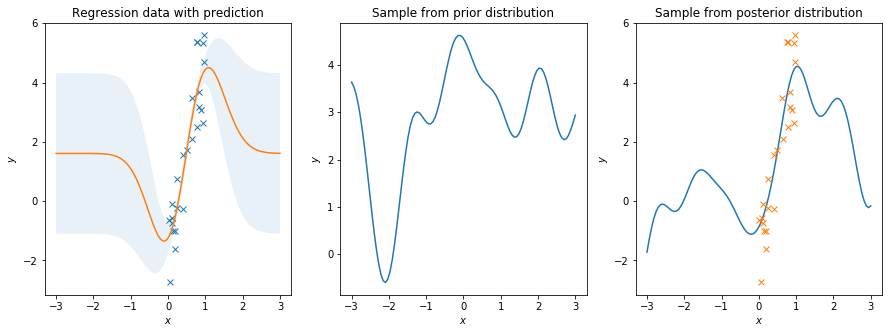

Text(0.5, 1.0, 'Underlying function with no randomness for comparison')

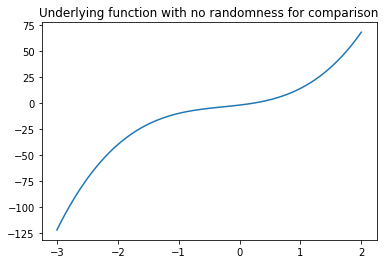

In [3]:
def data1(n):
    X=np.random.rand(n)
    y=-5*X**3+4*X**2+7*X-2+np.random.randn(n)
    return X,y

X1,y1=data1(25)

model_1 = GaussianFitter()
model_1.fit(X1,y1)
model_1.predict(X1,y1)

check_vec = np.linspace(-3,2,100)
plt.plot(check_vec,5*check_vec**3+4*check_vec**2+7*check_vec-2)
plt.title('Underlying function with no randomness for comparison')

The Gaussian process tends to fit fairly well in the sample range, but underestimates how large the values will get at the tails, demonstrated by the standard deviation boundaries being nowhere near the values at -3 and +2. This isn't unreasonable given that it has no data at these points, and the function is fairly smooth in the 0-1 range. Realistically we probably wouldn't try to predict something far away from the data without anything in its region to base our model around either. 

This highlights how Gaussian Processes are better used for interpolating existing data than trying to make far off predictions.

# Example 2

Lowest NLL achieved = 5.794847948551171


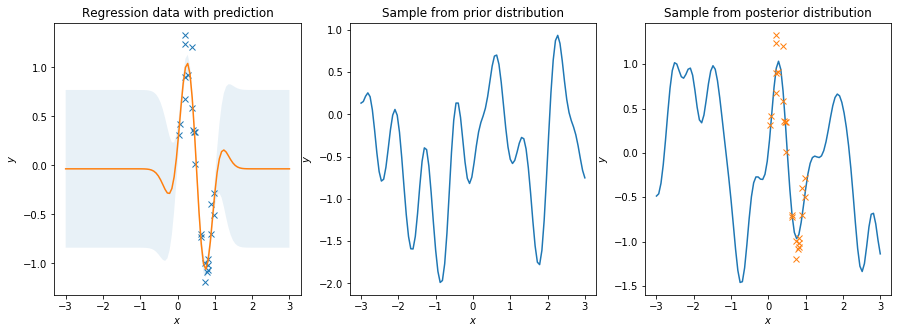

In [4]:
def data2(n):
    X=np.random.rand(n)
    y=np.sin(X*2*np.pi)+np.random.randn(n)/5
    return X,y

X2,y2=data2(25)

model_2 = GaussianFitter()
model_2.fit(X2,y2)
model_2.predict(X2,y2)

The process can pick up on the trend in the data and the uncertainty is only significant outside the region with data (without exceeding the actual peaks of the data) while achieving a good NLL score. If the data oscillates too fast in the region, which can be seen by increasing the parameter on pi on the y data, the distributions tend to flatten out. Presumably at that point the process interprets the data as just being noise rather than having a particular patten.

# Example 3 

Lowest NLL achieved = 80.77792657432761


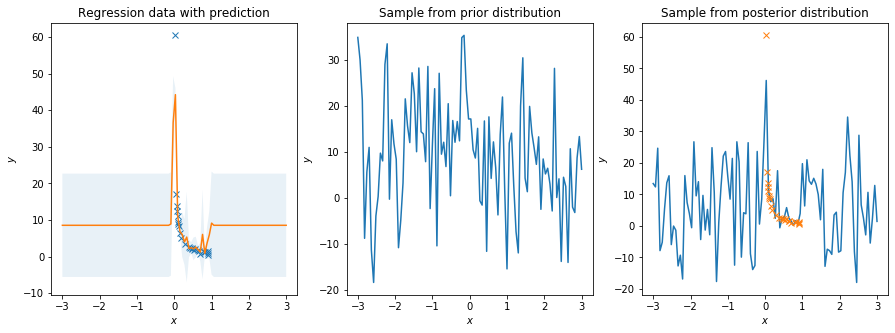

In [5]:
def data3(n):
    X=np.random.rand(n)
    y=np.divide(1,X)+np.random.randn(n)/5
    return X,y

X3,y3=data3(25)

model_3 = GaussianFitter()
model_3.fit(X3,y3)
model_3.predict(X3,y3)

The asymptotic nature of this function doesn't mesh well with Gaussian processes, as what looks like an outlier compared to the rest of the data causes a great deal of uncertainty. It's usually still pretty happy around the data parts, as far as standard deviations go, but can even have uncertainty in that region depending on the sample data.

This demonstrates how outliers can throw off Gaussian processes and cause excessive uncertainty. A different kernel might be able to handle these better, though.

# Example 4

Lowest NLL achieved = -23.377622086041757


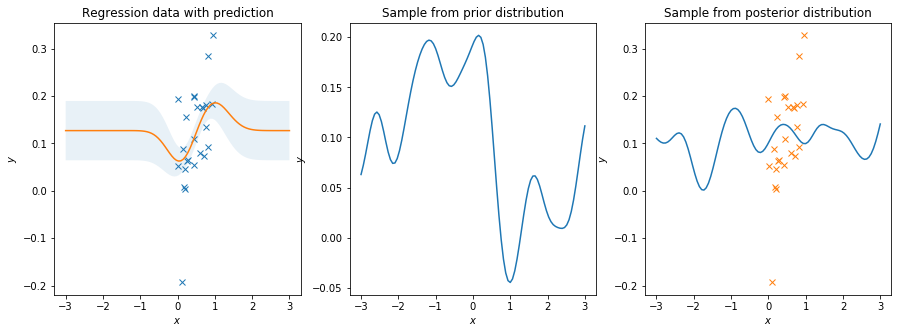

In [10]:
def data4(n):
    X=np.random.rand(n)
    y=scipy.stats.norm.pdf(X,2,1)+np.random.randn(n)/10
    return X,y

X4,y4=data4(25)

model_4 = GaussianFitter()
model_4.fit(X4,y4,y_std_scale=0.1) #This one tends to be more sensitive to values of sigma in terms of numerical instability so we make it a bit bigger
model_4.predict(X4,y4)

#Might need to run a few times to avoid singular matrix errors. Shouldn't take more than three or four runs though.

This model achieves good ilkelihood, indicated by the low NLL, but ignores a lot of the data at the higher and lower y values. Given that there are non-trivial standard deviations within the sample range, the model seems to intepret a lot of the data as noise. That said, the level of noise is fairly high in this data set, so the model's result isn't unreaosnable.

On some occasions the prior and posterior distributions are flat, with zero standard deviations on the regression. This may be a result of nearly equal data samples on either side of the mean, and the minimum NLL occuring when everything outside the mean is assumed to be noise.